In [1]:
# Set project root
import sys
import os

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import recover_pose_from_homography, estimate_intrinsic_from_homography
from src.plotting import draw_3d_axes, draw_box

In [3]:
# Load template and images
template_path = '../assets/templates/template_00.jpg'
image_paths = [
    '../assets/images/image_00.jpg',
    '../assets/images/image_01.jpg',
    '../assets/images/image_02.jpg',
]

template = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
images = [cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for image_path in image_paths]

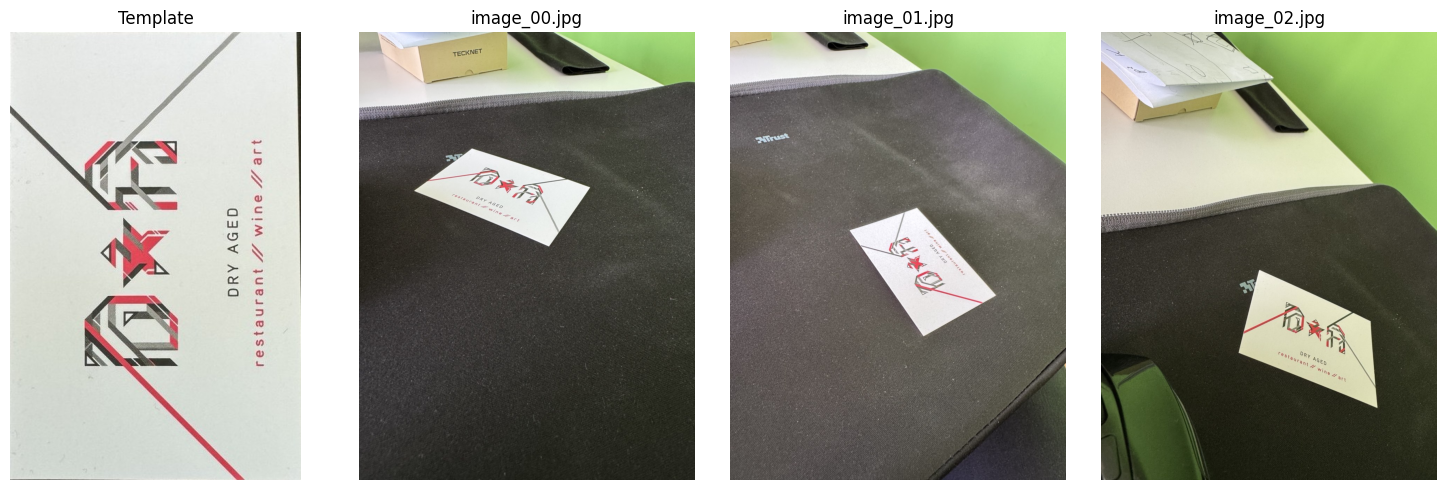

In [4]:
# Plot template and images on the same line
fig, axes = plt.subplots(1, len(images) + 1, figsize=(15, 5))
axes[0].imshow(template)
axes[0].set_title('Template')
axes[0].axis('off')
for ax, image, image_path in zip(axes[1:], images, image_paths):
    ax.imshow(image)
    ax.set_title(image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Perform feature extraction on template and images using SIFT
sift = cv2.SIFT_create()
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_images = []
descriptors_images = []
for image in images:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    keypoints_images.append(keypoints)
    descriptors_images.append(descriptors)

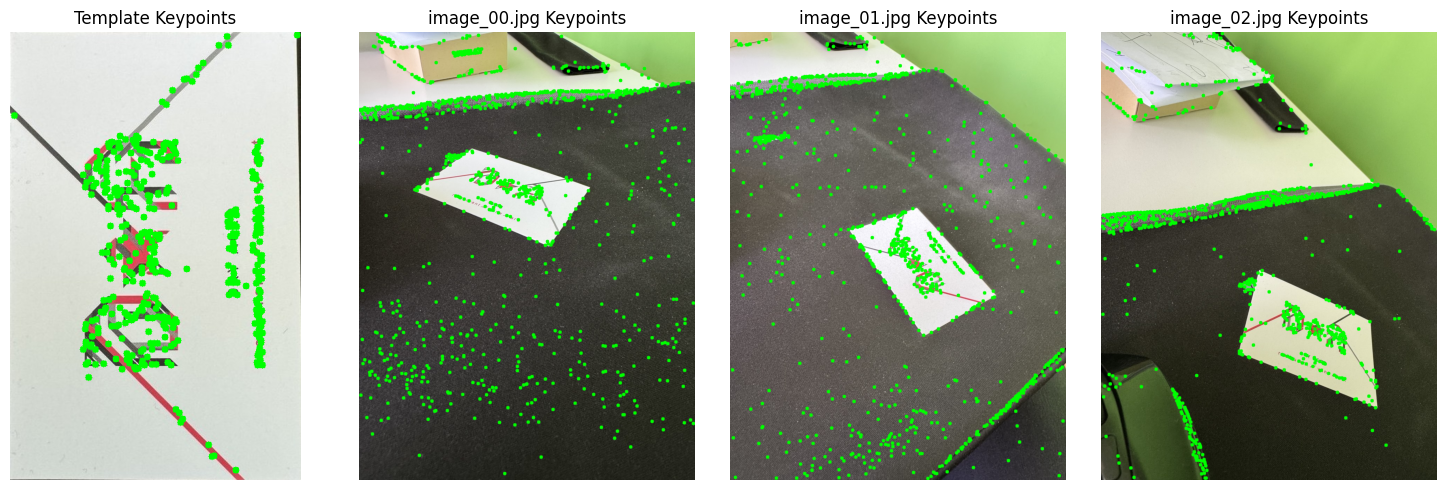

In [6]:
# Display the keypoints on the template and images
def draw_keypoints(image, keypoints):
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 5, (0, 255, 0), -1)
    return image_with_keypoints

fig, axes = plt.subplots(1, len(images) + 1, figsize=(15, 5))
axes[0].imshow(draw_keypoints(template, keypoints_template))
axes[0].set_title('Template Keypoints')
axes[0].axis('off')
for ax, image, keypoints, image_path in zip(axes[1:], images, keypoints_images, image_paths):
    ax.imshow(draw_keypoints(image, keypoints))
    ax.set_title(image_path.split('/')[-1] + ' Keypoints')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Print the number of keypoints detected in each image
print(f"Number of keypoints in template: {len(keypoints_template)}")
for i, (image_path, keypoints) in enumerate(zip(image_paths, keypoints_images)):
    print(f"Number of keypoints in {image_path.split('/')[-1]}: {len(keypoints)}")

Number of keypoints in template: 542
Number of keypoints in image_00.jpg: 1303
Number of keypoints in image_01.jpg: 1222
Number of keypoints in image_02.jpg: 1114


In [8]:
# Perform matching using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = []
for i, (descriptors_image, keypoints_image) in enumerate(zip(descriptors_images, keypoints_images)):
    match = bf.match(descriptors_template, descriptors_image)
    matches.append(match)
    matches[i] = sorted(matches[i], key=lambda x: x.distance)
    print(f"Number of matches in {image_paths[i].split('/')[-1]}: {len(matches[i])}")

Number of matches in image_00.jpg: 179
Number of matches in image_01.jpg: 179
Number of matches in image_02.jpg: 204


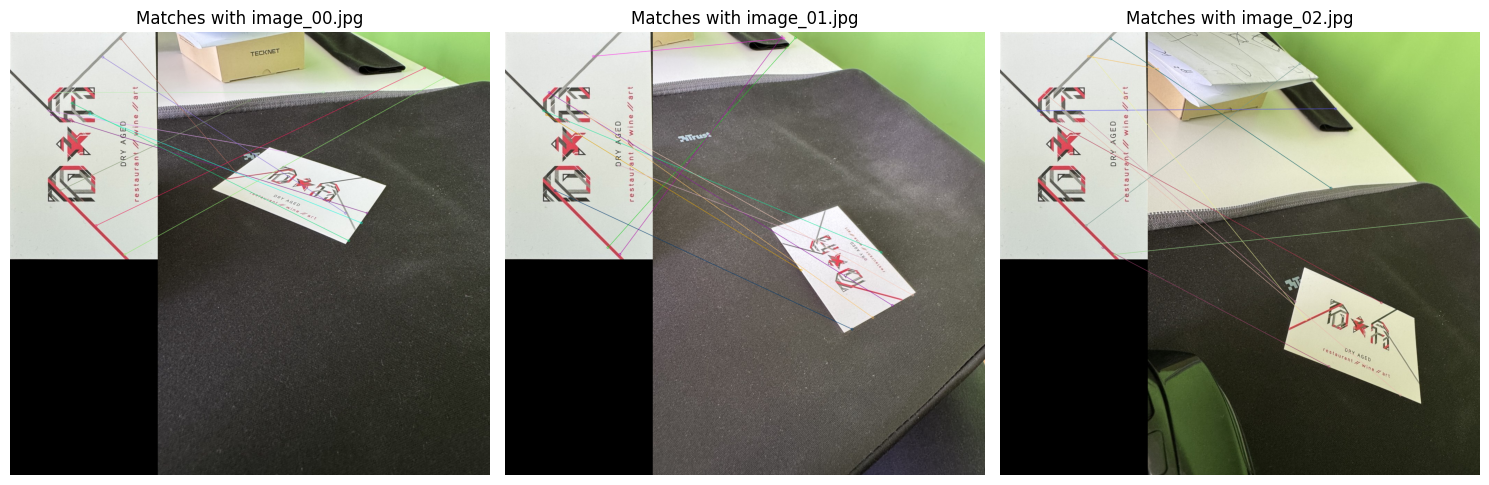

In [9]:
# Draw the matches
def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return image_matches

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for ax, image, keypoints, match, image_path in zip(axes, images, keypoints_images, matches, image_paths):
    ax.imshow(draw_matches(template, keypoints_template, image, keypoints, match))
    ax.set_title('Matches with ' + image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

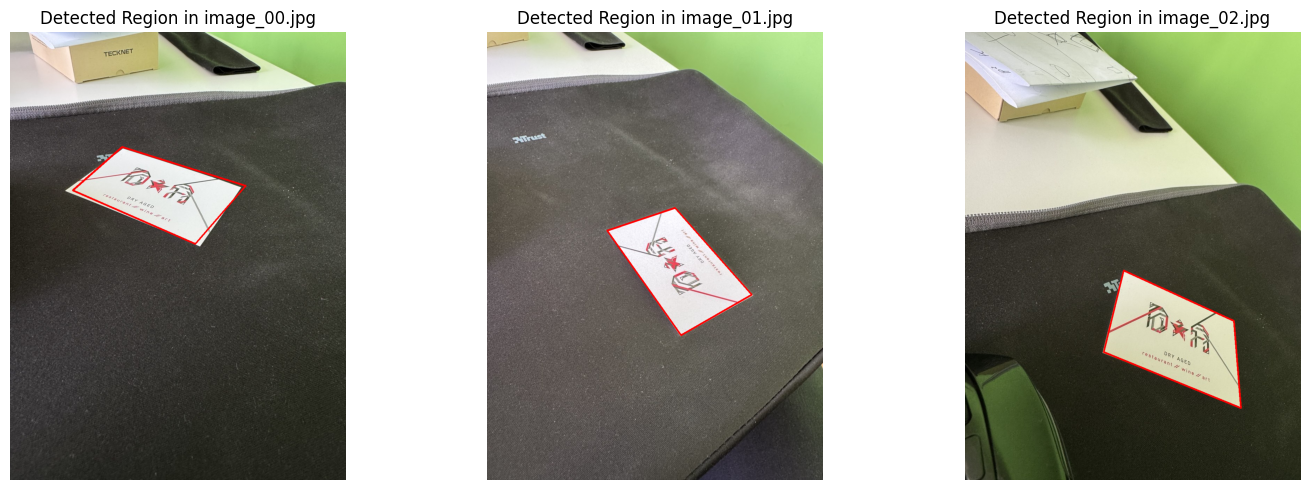

In [10]:
# Compute the homography matrix for each image
def compute_homography(matches, keypoints1, keypoints2):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M, mask

# Draw a rectangle in each image to show the detected region
def draw_rectangle(image, M):
    h, w = template.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    image_with_rectangle = cv2.polylines(image.copy(), [np.int32(dst)], True, (255, 0, 0), 3)
    return image_with_rectangle

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for ax, image, keypoints, match, image_path in zip(axes, images, keypoints_images, matches, image_paths):
    M, mask = compute_homography(match, keypoints_template, keypoints)
    ax.imshow(draw_rectangle(image, M))
    ax.set_title('Detected Region in ' + image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Only work with image_01 for now
image_index = 1
image = images[image_index]

# Compute the homography matrix for image_01
H, mask = compute_homography(matches[image_index], keypoints_template, keypoints_images[image_index])

# Define known camera intrinsics
ux = image.shape[1] / 2
uy = image.shape[0] / 2

# Estimate K using the homography matrix
K = estimate_intrinsic_from_homography(H, (ux, uy))

# Recover the pose using the homography matrix and camera intrinsics
R, t = recover_pose_from_homography(H, K)

[INFO] f_squared (dot): 879246.7293414369
[INFO] Using orthogonality-only estimate (norm-based estimate invalid)


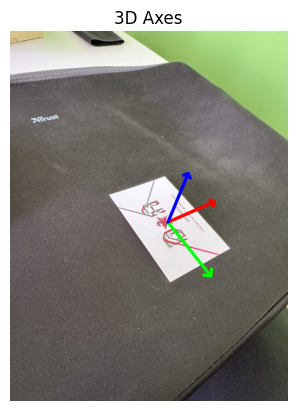

In [12]:
t_shape = template.shape[:2]

# Draw 3D axes using the new function
img = draw_3d_axes(image, R, t, K, template_shape=t_shape)

plt.imshow(img)
plt.title("3D Axes")
plt.axis('off')
plt.show()

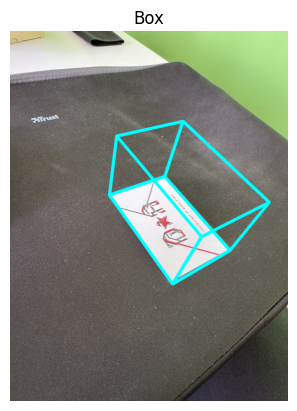

In [16]:
# Draw a box on the template instance
w, h, d = t_shape[1], t_shape[0], t_shape[1]
box_image = draw_box(image, R, t, K, corners_3d=None, width=w, height=h, depth=d)

plt.imshow(box_image)
plt.title("Box")
plt.axis('off')
plt.show()